# Initialization

In [6]:
%load_ext autoreload
%autoreload 2

from jlib.transformer_char_predictor import TransformerCharPredictor, History
import jlib.data_utils as data_utils
import torch
import torch.nn as nn
import numpy as np
from torchprofile import profile_macs
text = ""
with open('data/sequence.txt', 'r') as f:
    text = f.read()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
seqlen = 10
def train_and_plot(seqlen: int):
    data = data_utils.gen_datasets(text, seqlen)
    train_data = data['train_dataset']
    val_data = data['val_dataset']
    alphabet: data_utils.Alphabet = data['alphabet']

    train_fetcher = data_utils.gen_data_loader(
        train_data,
        batch_size=32,
        workers = 6,
        cpu_prefetch= 20,
        gpu_prefetch=20
    )

    val_fetcher = data_utils.gen_data_loader(
        val_data,
        batch_size=len(val_data),
        workers = 6,
        cpu_prefetch= 10,
        gpu_prefetch=10
    )

    # model

    model = TransformerCharPredictor(
        alphabet_size = len(alphabet),
        max_len = seqlen,
        hidden_dim = 2048,
        inner_dim = 2048,
        num_attn_heads = 2,
        num_attn_layers=3,
        cls_head_dims=[256],
        dropout = 0.3
    )

    
# Model parameter count: 1,790,380
# Model MACs: 568,279,052



    hist = model.train_model(
        epochs=200,
        train_fetcher=train_fetcher,
        val_fetcher=val_fetcher,
        optimizer = torch.optim.Adam,
        optimizer_kwargs={
            'lr': 3e-5,
            'betas': (0.9, 0.98),
            'eps': 1e-9,
            'weight_decay': 1e-5
        },
        min_accuracy=1,
        max_negative_diff_count=20,
        stop_on_plateau=True,
        print_epoch=1,
        header_epoch = 15,
    )

    fig = hist.plot_training(f'Small Corpus, Sequence Length {seqlen}')
    fig.savefig(f'latex/images/p1-{seqlen}.png')
    hist.save(f'models/history/p1-{seqlen}.json')
    hist_load = History.from_json(f'models/history/p1-{seqlen}.json')
    
    del train_fetcher, val_fetcher, train_data, val_data, data, model, alphabet
    





# Training

In [ ]:
train_and_plot(10)


Begin init data loader


Batch Size: 0.00244140625 MiB
Data Loader init time: 0.132543 s
Begin init fetcher
Fetcher init time: 0.212095 s
Begin init data loader
Batch Size: 0.00335693359375 MiB
Data Loader init time: 0.129284 s
Begin init fetcher
Fetcher init time: 0.209002 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.850190      |      3.625521      |      3.315374      |     17.272727      |         inf        |      5.119435      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      0.455135      |      3.357372      |      3.152435      |     23.636363      |     36.842102      |      5.119435      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |      0.458162      |      3.230958      |      2.992678      |     26.590911      |

Begin init data loader
Batch Size: 0.0048828125 MiB
Data Loader init time: 0.128906 s
Begin init fetcher
Fetcher init time: 0.210079 s
Begin init data loader
Batch Size: 0.003509521484375 MiB
Data Loader init time: 0.233177 s
Begin init fetcher
Fetcher init time: 0.315298 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.427533      |      3.718773      |      3.474457      |     15.217391      |         inf        |      2.797754      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      0.341570      |      3.452894      |      3.321510      |     20.000000      |     31.428577      |      2.797754      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |      0.358353      |      3.339189      |      3.253685      |     22.391304      |

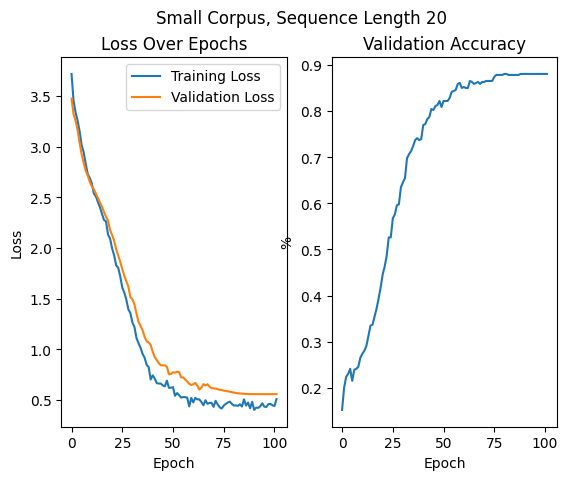

In [ ]:
train_and_plot(20)


In [ ]:
train_and_plot(30)


Begin init data loader
Batch Size: 0.00732421875 MiB
Data Loader init time: 0.143801 s
Begin init fetcher
Fetcher init time: 0.232424 s
Begin init data loader
Batch Size: 0.003662109375 MiB
Data Loader init time: 0.210854 s
Begin init fetcher
Fetcher init time: 0.287611 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.370343      |      3.710352      |      3.448905      |     15.000001      |         inf        |      2.798563      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      0.315077      |      3.446579      |      3.272569      |     15.208334      |      1.388888      |      2.798563      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |      0.326019      |      3.330094      |      3.181653      |     20.625000      |

Exception ignored in: <function _releaseLock at 0x7f3640477ce0>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 13178, 13180, 13181) exited unexpectedly